# URL clustering based on similarity

- urls_df = full dataset
- urls_tdf = full dataset transformed
- urls_tsdf = sampled dataset transformed

## Imports & Helper functions

### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

### Helper functions

In [48]:
from polyleven import levenshtein

def levenshtein_pdist(u, v):
    if isinstance(u, np.ndarray):
        u = u[0]
    if isinstance(v, np.ndarray):
        v = v[0]
    return levenshtein(u,v)

class SklearnStringTrick:
    """
    String clustering trick shown at:
        https://scikit-learn.org/0.16/faq.html#how-do-i-deal-with-string-data-or-trees-graphs

    Class structure allows for method reuse over distinct data

    """

    def __init__(self, dataset=[]):
        self.dataset = dataset

    def lev_dist_sklearn_urls(self, x, y):
        i, j = int(x[0]), int(y[0])  # extract indices
        return levenshtein(self.dataset[i], self.dataset[j])

In [4]:
string_trick = SklearnStringTrick()

## Preprocessing

In [5]:
urls_df = pd.read_csv(
    "datasets/kaggle_siddharta_malicious_benign.csv",
    delimiter=",",
    dtype={"url": "string"},
)

urls_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [6]:
# Create OneHotEncoded features from type

from sklearn.preprocessing import OneHotEncoder

ohenc = OneHotEncoder(sparse_output=False)
type_ohenc = pd.DataFrame(
    ohenc.fit_transform(urls_df["type"].values.reshape(-1, 1)),
    columns=ohenc.categories_[0],
).astype(bool)

# URLs_transformed df
urls_tdf = pd.concat([urls_df, type_ohenc], axis=1)

In [7]:
urls_tdf["malicious"] = ~urls_tdf["benign"]
urls_tdf.head()

,url,type,benign,defacement,malware,phishing,malicious
0,br-icloud.com.br,phishing,False,False,False,True,True
1,mp3raid.com/music/krizz_kaliko.html,benign,True,False,False,False,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,True,False,False,False,False
3,http://www.garage-pirenne.be/index.php?option=...,defacement,False,True,False,False,True
4,http://adventure-nicaragua.net/index.php?optio...,defacement,False,True,False,False,True


## Data exploration

### Levenshtein distances

#### URL unchanged

In [8]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 50000

urls_tsdf = pd.DataFrame()

urls_tsdf["sample1"] = urls_tdf.sample(n=N_SAMPLES, random_state=123).reset_index(
    drop=True
)["url"]
urls_tsdf["sample2"] = urls_tdf.sample(n=N_SAMPLES, random_state=545).reset_index(
    drop=True
)["url"]

In [9]:
# Calculate Levenshtein distance on each pair (N_SAMPLES distances)
urls_tsdf["levenshtein_distance"] = urls_tsdf.apply(
    lambda row: levenshtein(row.sample1, row.sample2), axis=1
)

Text(0.5, 1.0, "Distribution of levenshtein's distances over 50000 random samples")

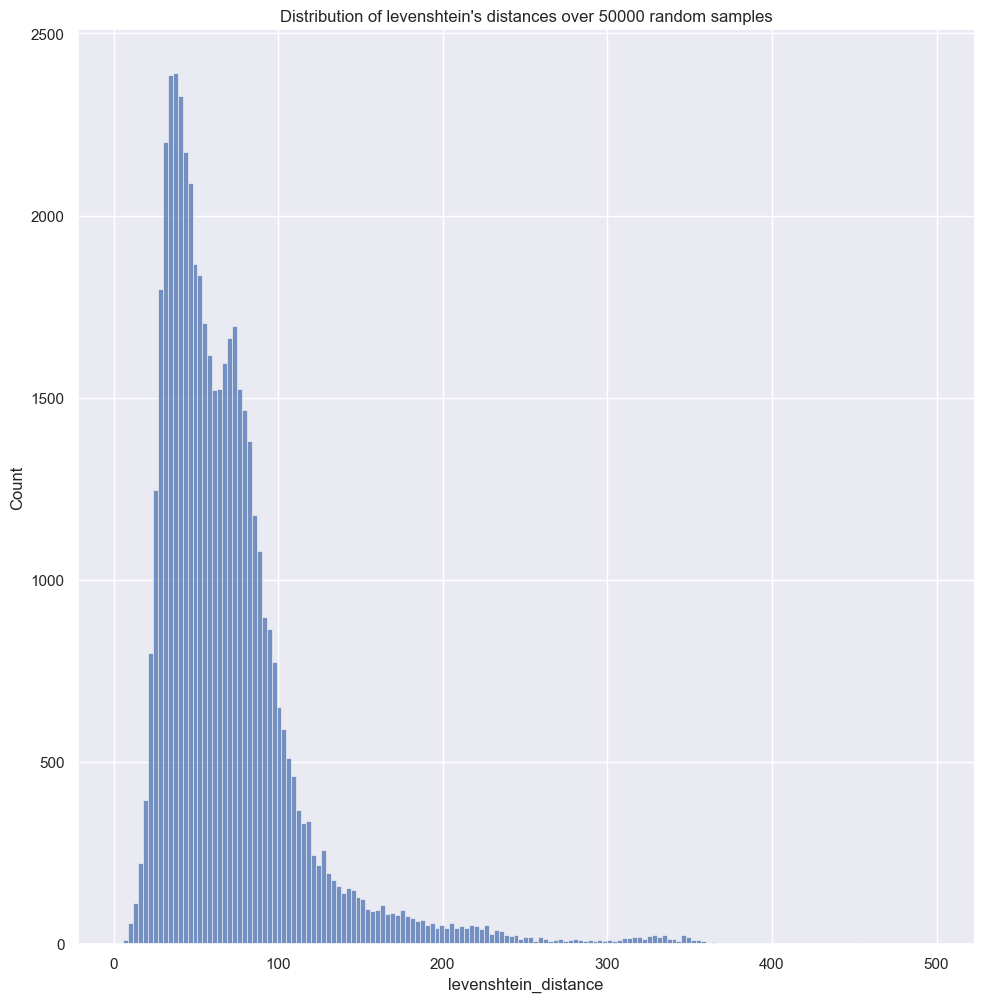

In [10]:
sns.displot(
    urls_tsdf[urls_tsdf["levenshtein_distance"] < 500],
    x="levenshtein_distance",
    binwidth=3,
    height=10,
)
plt.title(f"Distribution of levenshtein's distances over {N_SAMPLES} random samples")

## Experiments

### Unchanged URLs

Keep `urls_tdf` intact for this section to show what it should

#### DBSCAN

DBSCAN will not work. It needs $\mathcal{O}(n^2)$

#### Hierarchical clustering

In [68]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [64]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 1000

urls_tsdf = urls_tdf.sample(n=N_SAMPLES, random_state=111).reset_index(
    drop=True
)

In [65]:
# Calculate pairwise distances between URLs using levenshtein distance function
X = urls_tsdf['url'].values.reshape(-1,1)
distances = pdist(X, metric=levenshtein_pdist)

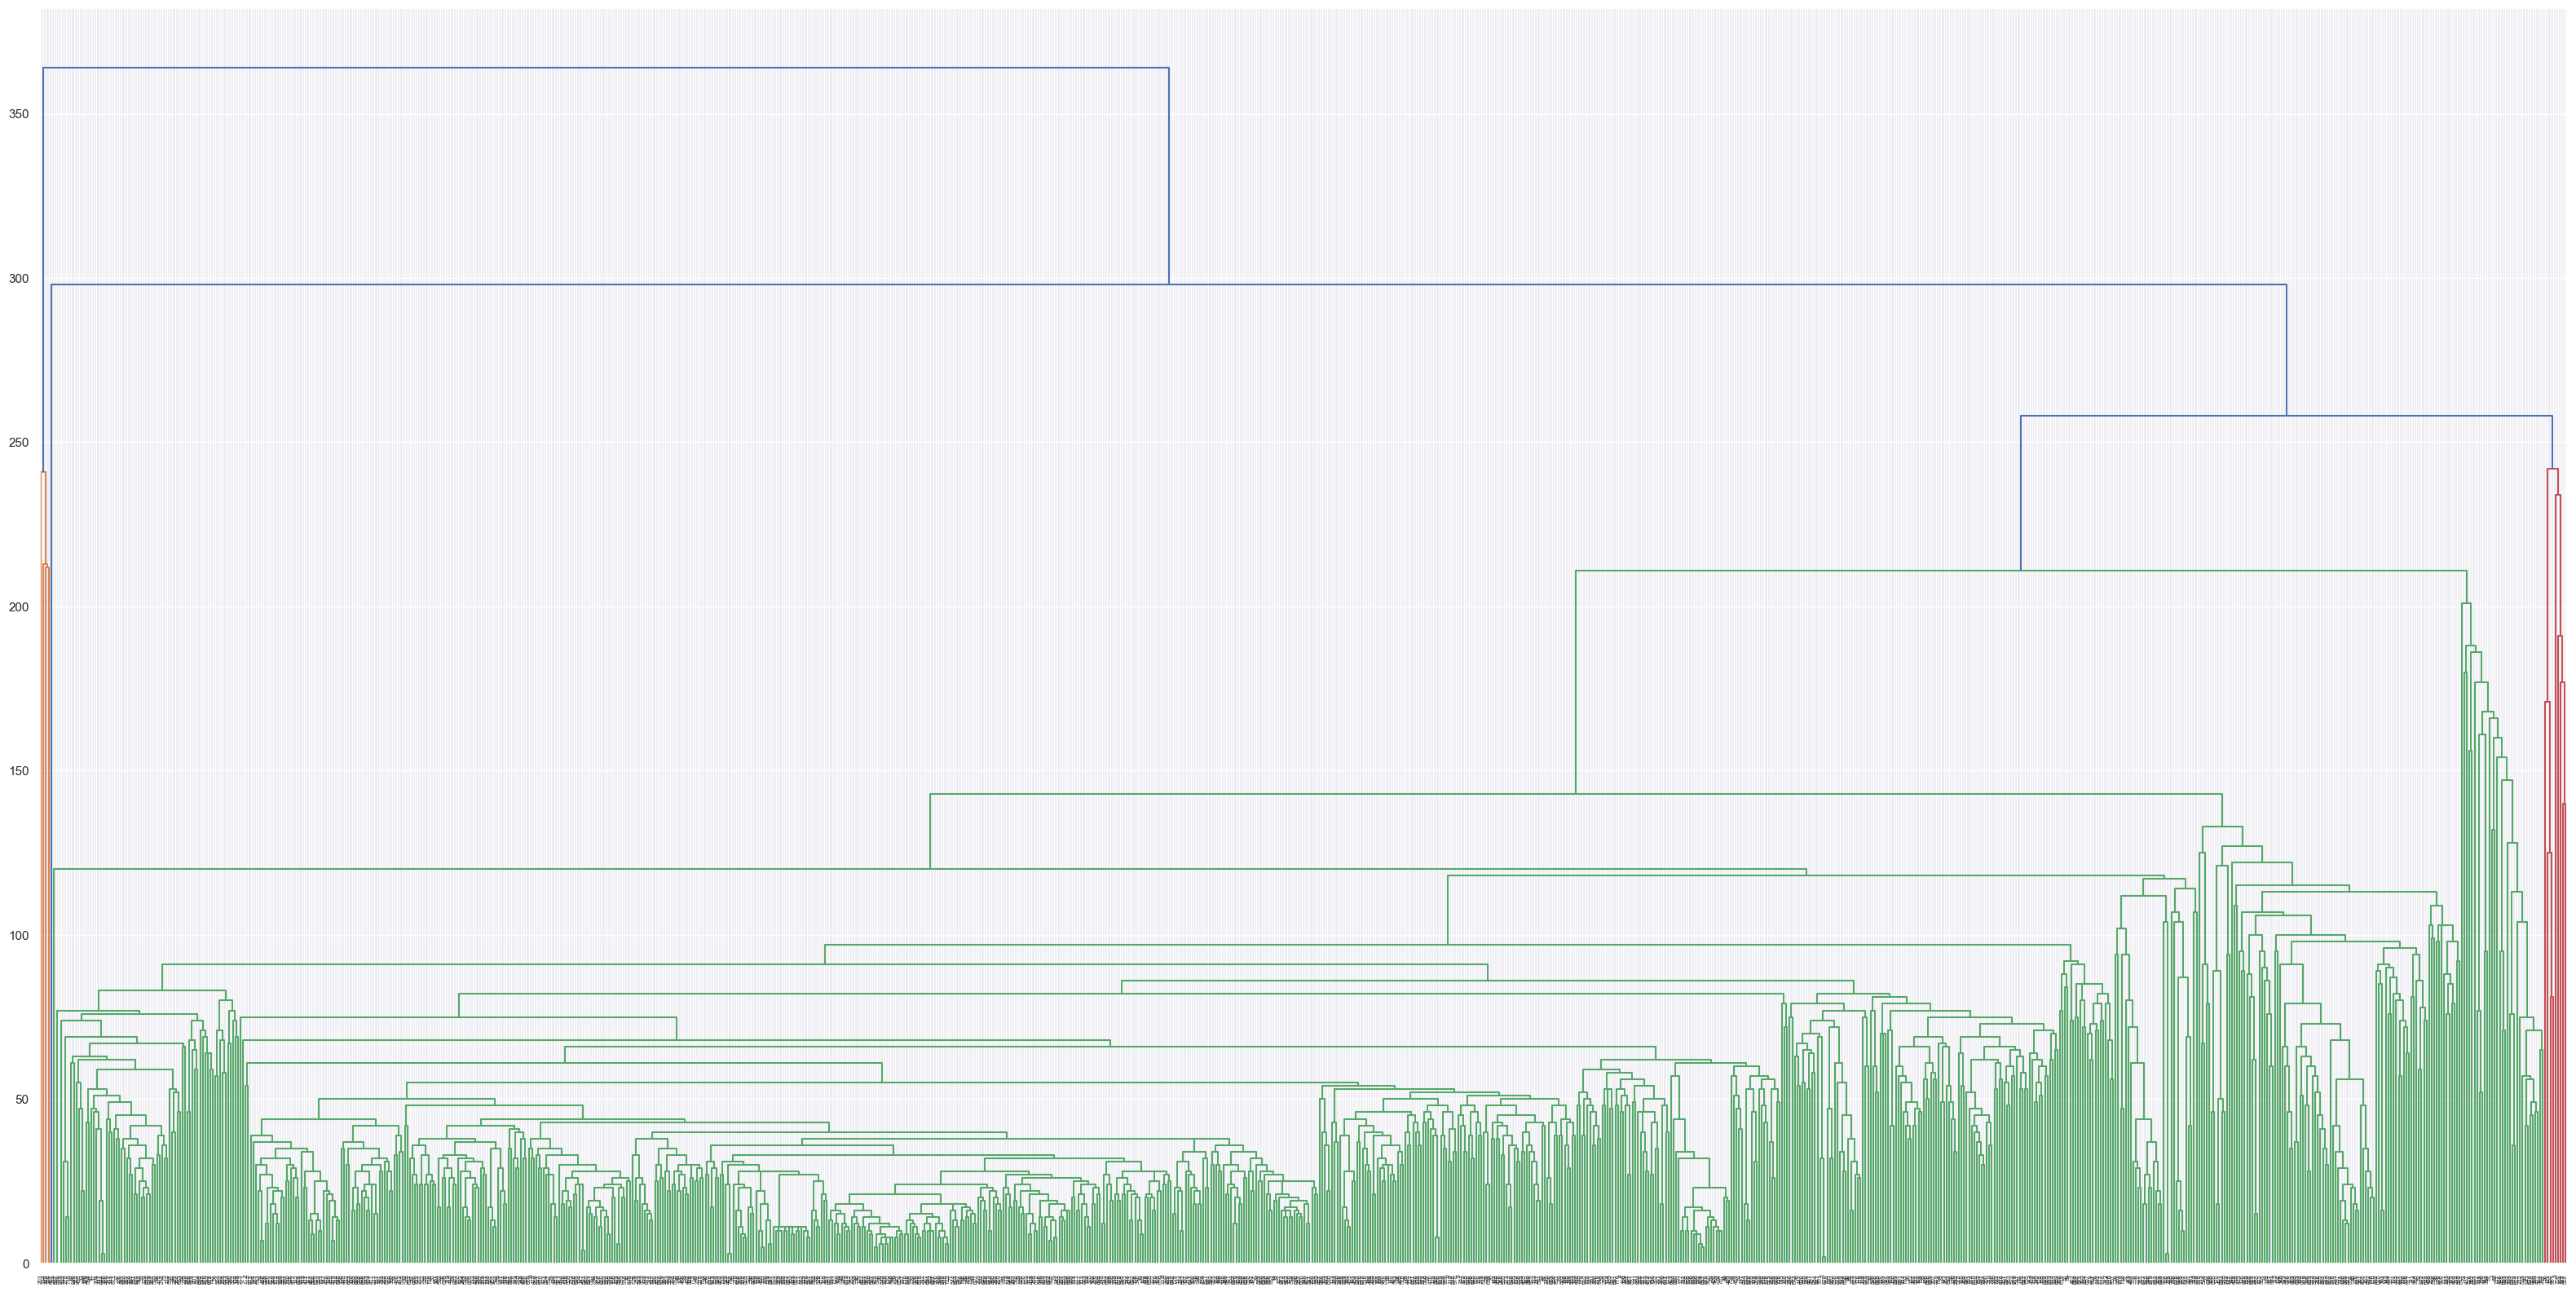

In [85]:
# Perform hierarchical clustering
Z = linkage(distances, 'complete')

# Draw dendrogram for visual cutoff selection
fig, ax = plt.subplots(figsize=(40, 20))
dendrogram(Z, ax=ax)


fig1 = fig
plt.show()

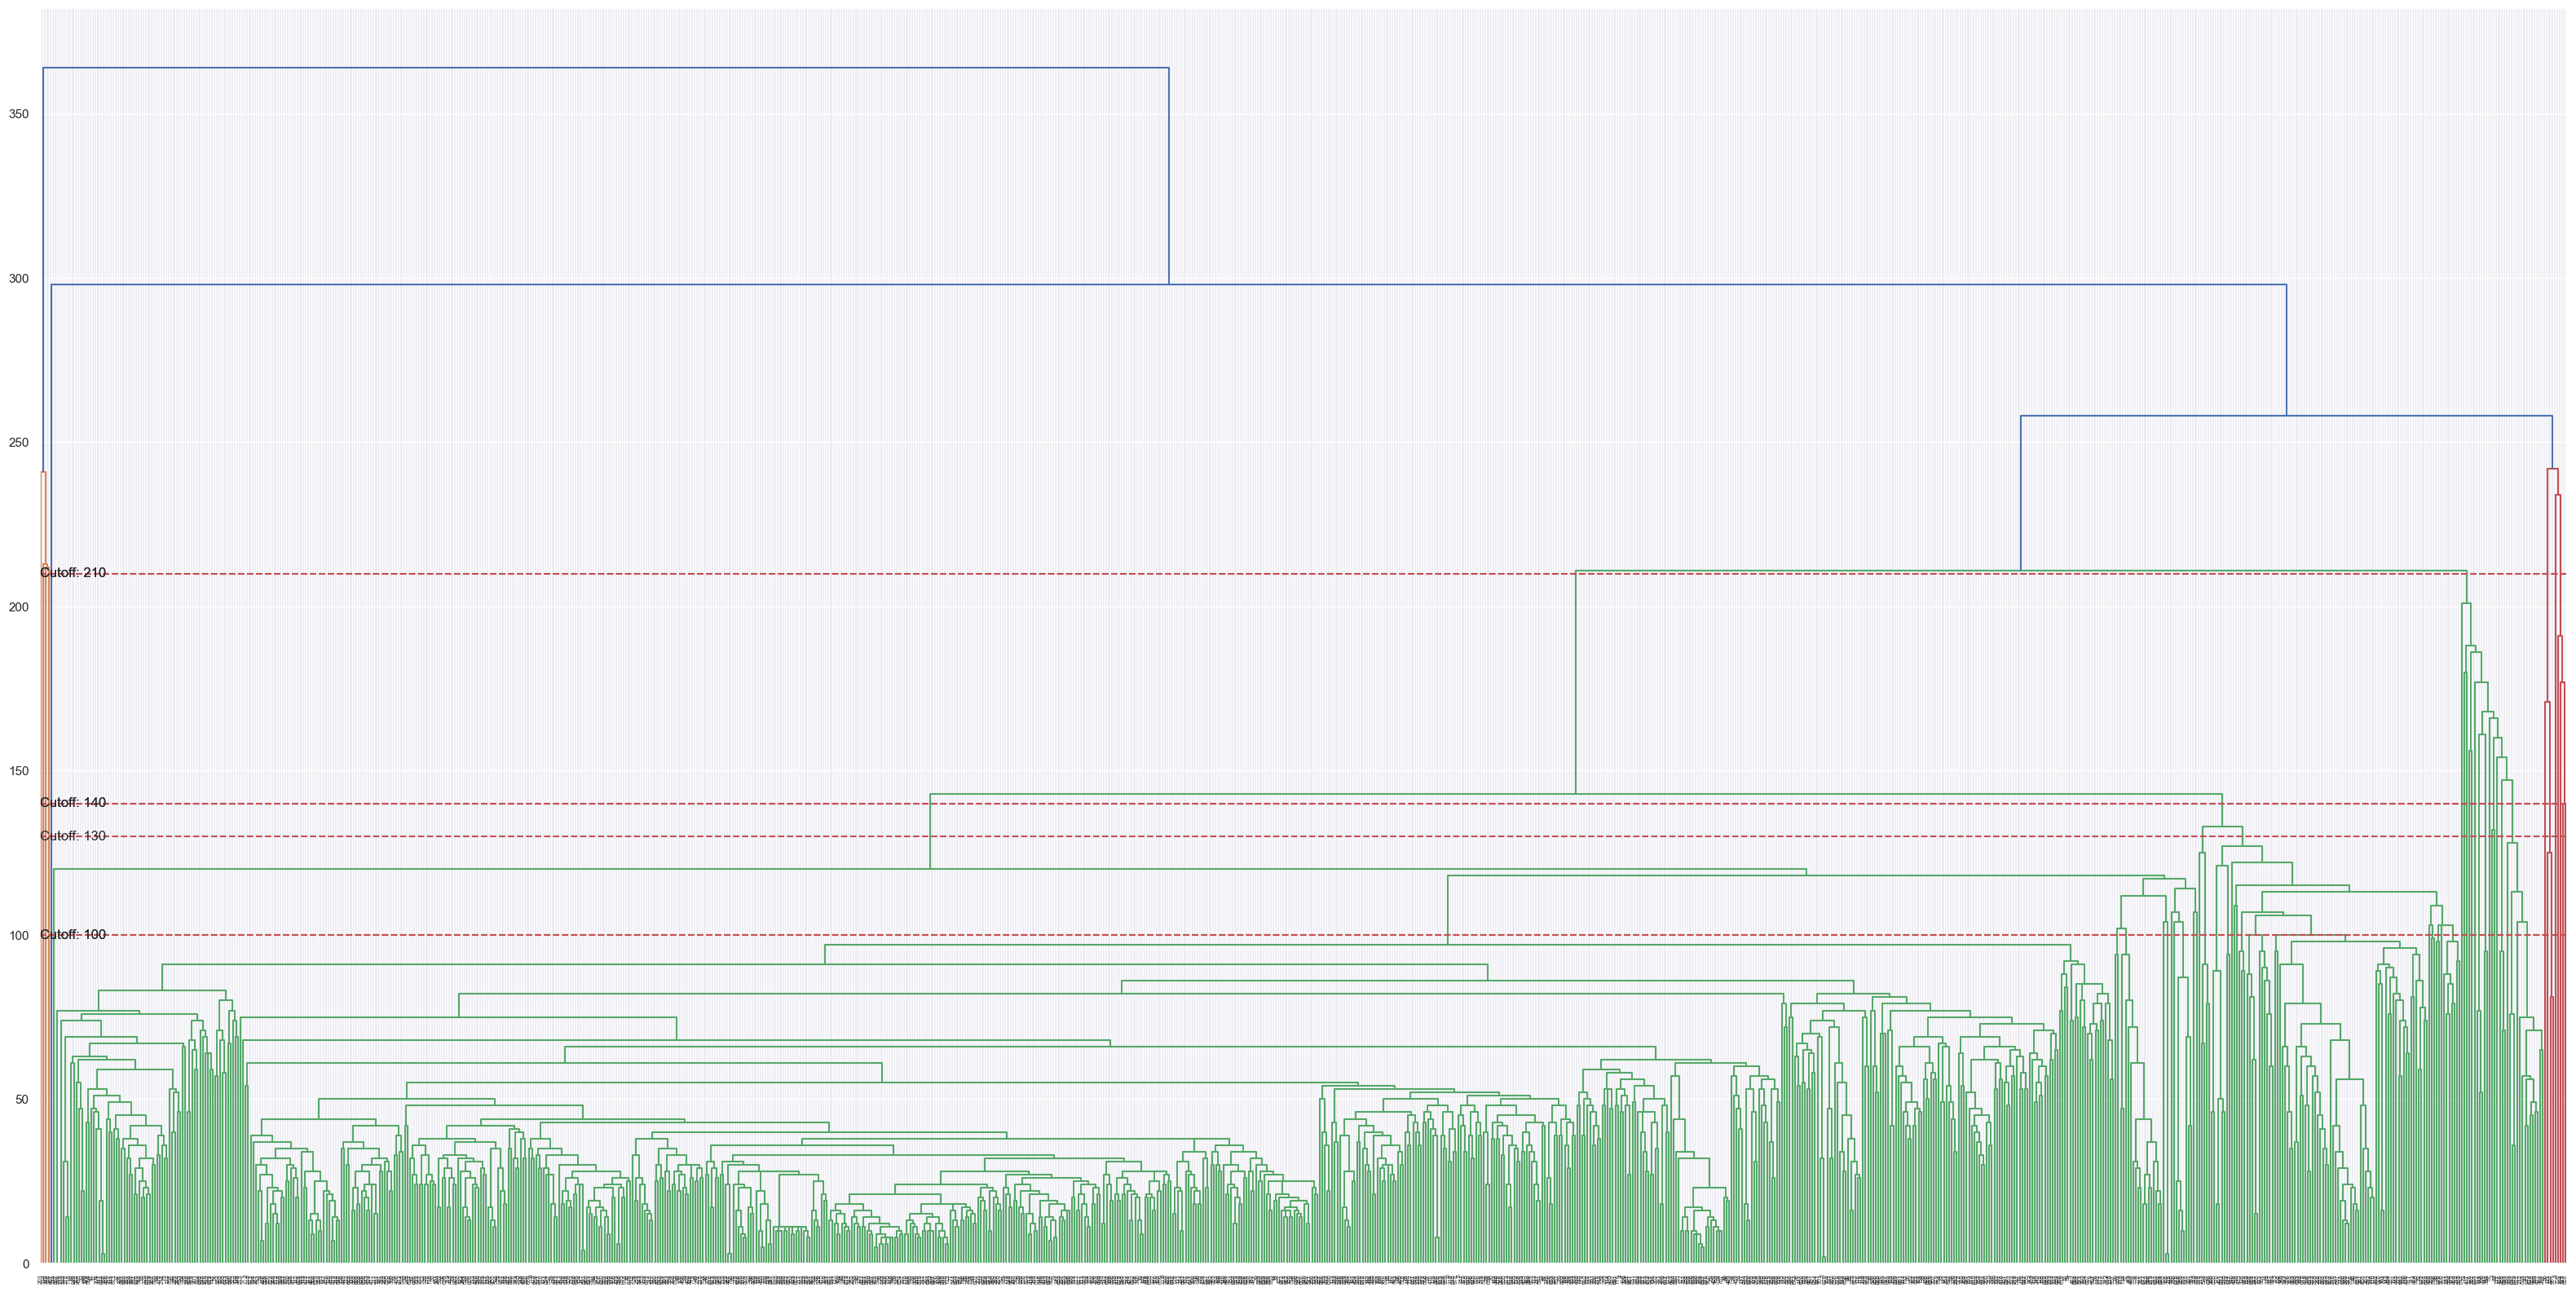

In [87]:
CUTOFF = [100, 130, 140, 210]

# Load the figure object from the previous cell
fig = fig1

# Get the axes object from the figure
ax = fig.axes[0]

# Add the cutoff horizontal line
# Add horizontal line
for cutoff in CUTOFF:
    ax.axhline(y=cutoff, color='r', linestyle='--')
    ax.text(x=ax.get_xlim()[0], y=cutoff, s=f'Cutoff: {cutoff}', va='center')


# Show the plot
fig

In [89]:
# Determine the optimal number of clusters
max_d = 140  # set the threshold distance
clusters = fcluster(Z, max_d, criterion='distance')

In [90]:
# Add cluster labels to the original dataset
urls_tsdf['cluster'] = clusters

# Print the resulting clusters
print(urls_tsdf.groupby('cluster')['url'].apply(list))

cluster
1     ['9d345009-a-62cb3a1a-s-sites.googlegroups.com...
2     ['9d345009-a-62cb3a1a-s-sites.googlegroups.com...
3     ['9d345009-a-62cb3a1a-s-sites.googlegroups.com...
4     ['9d345009-a-62cb3a1a-s-sites.googlegroups.com...
5     [stars.nhl.com/club/player.htm?id=8474802, htt...
6     [http://extratorrent.cc/torrent_download/41911...
7     [www.notificari.eset.ro/web.scr/cmd/login/cgi-...
8     [https://esparklight.com/wp-admin/login.php?cm...
9     [http://bestblackhatforum.com/Thread-%E2%96%88...
10    [http://www.pubyun.com/blog/deveops/linux%e4%b...
11    [http://www.galerie-unterm-maulbeerbaum.de/ind...
12    [http://buzzfil.net/article/5378/c-mignon/on-v...
13    [update.paypal-com.service.cmd.activation.suce...
14    [http://shantasells.com/component/mailto/index...
15    [http://centrofierachiuduno.com/index.php?opti...
16    [http://maybank2u.com.my/mbb_info/m2u/public/e...
17    [http://mirtesen.ru/url?e=simple_click&blog_po...
18    [http://appleid.apple.co.uk.cgi-bi

#### Evaluation of cluster quality based on cutoff